In [1]:
import tensorflow as tf

#le code suivant divise le premier GPU (GPU 0) en 4 GPU -périphériques- virtuels. Chacun 2Gio de RAM.
#les instructions suivantes doivent être effectuées juste après l'importation du module tensorflow.

physical_gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_virtual_device_configuration(
    physical_gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

In [2]:
# imports commun
import numpy as np
import os

# pour rendre stable l'exécution relativement aux nombres aléatoire générés.
np.random.seed(42)

# pour une meilleure visibilité des figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os

from tensorflow import keras



In [3]:
strategy = tf.distribute.MirroredStrategy()
print('Nombre de périphériques (GPU): {}'.format(strategy.num_replicas_in_sync))

Nombre de périphériques (GPU): 1


In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [5]:
num_train_examples = x_train.shape[0]
num_test_examples = x_test[0]

BUFFER_SIZE = 1000

x_valid, x_train = x_train [:5000], x_train[5000:]
y_valid, y_train = y_train [:5000], y_train[5000:]

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).map(scale).batch(BATCH_SIZE)
eval_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(scale).batch(BATCH_SIZE)



In [6]:
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3),padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10,activation='softmax'),
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [7]:
EPOCHS = 30

from time import time
t0 = time()

history = model.fit(train_dataset, epochs=EPOCHS,validation_data=valid_dataset)
tt = time() - t0
print("classifier trained in {} seconds".format(round(tt,3)))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


704/704 [==============================] - 28s 18ms/step - loss: 1.5356 - accuracy: 0.4504 - val_loss: 1.2017 - val_accuracy: 0.5662
Epoch 2/30
704/704 [==============================] - 10s 15ms/step - loss: 1.1003 - accuracy: 0.6106 - val_loss: 0.9730 - val_accuracy: 0.6616
Epoch 3/30
704/704 [==============================] - 10s 15ms/step - loss: 0.9051 - accuracy: 0.6825 - val_loss: 0.8923 - val_accuracy: 0.6886
Epoch 4/30
704/704 [==============================] - 10s 14ms/step - loss: 0.7972 - accuracy: 0.7223 - val_loss: 0.8798 - val_accuracy: 0.7020
Epoch 5/30
704/704 [==============================] - 10s 15ms/step - loss: 0.7178 - accuracy: 0.7495 - val_loss: 0.7403 - val_accuracy: 0.7476
Epoch 6/30
704/704 [==============================] - 11s 16ms/step - loss: 0.6565 - accuracy: 0.7745 - val_loss: 0.7419 - val_accuracy: 0.7526
Epoch 7/30
704/704 [==============================] - 9s 13ms/step - loss: 0.6030 - accuracy: 0.7928 - val_loss: 0.6401 - val_accuracy: 0.7798
Epoc

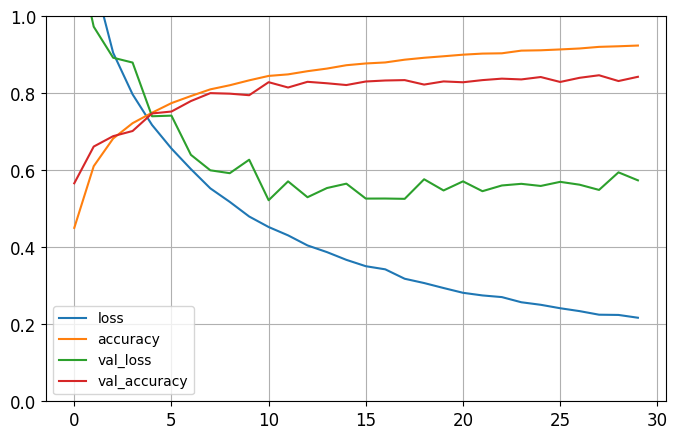

In [8]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()